# COVID-19
#### Finding the countries with similar spread 

***

This notebook aims to clarify how the nearest neighbours for each country are found. This is useful because there is a high chance that alike countries will keep evolving in the same way.

In [0]:
import os
os.chdir('..')

In [0]:
import warnings 
import statistics

import numpy   as np 
import pandas  as pd

import seaborn as sns
from matplotlib import pyplot as plt
# sns.set()
from core.data import utils  as dataUtils

from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Loading data

The latest data can be fetched by running ```python scripts/fetch_latest_data.py```. This will download the new global data from Johns Hopkins University GitHub [repo](https://github.com/CSSEGISandData/COVID-19) (they update the data on a daily basis.) Also, it will convert it to a more convenient format, namely the one used in [Kaggles COVID-19 spread](https://www.kaggle.com/c/covid19-global-forecasting-week-4) competition. The main reason for converting the data was that when I first started working on this project only the Kaggle data was available, and rather that rewriting a good portion of the code, I found this solution to be easier. 

The dataset contains the spread evolution for each country (except USA). Large countries are divided into zones for better granularity.

In [0]:
allData = pd.read_csv('assets/covid_spread.csv', parse_dates=['Date'])
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


Preprocess the input dataframe. Fill empty states with their country names (this will make working with regions much easier).

In [0]:
def preprocess_data(df):
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

In [0]:
allData = preprocess_data(allData)
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


Because exploratory data analysis is beyond the purpose of this notebook, I leave you the following reccomandation on Kaggle:
- [COVID19-Explained through Visualizations](https://www.kaggle.com/anshuls235/covid19-explained-through-visualizations)

## Approach

### Comparing 2 countries

Two countries are compared by incrementally sliding the source country **S** over the cadidate country **C** and computing the error (difference) between them. If **C** is not as evolved as **S**, we do not make the comparison. 

In [0]:
def compare_sequence(source, candidate, errorFunc):
    minError = np.inf
    minIdx   = -1

    # only check the countries that can influence
    if len(candidate) > len(source):
        noWindows  = len(candidate) - len(source)
        windowSize = len(source)

        # sliding window over candidate country
        for i in range(0, noWindows):

            # compute loss
            error = errorFunc(source, candidate[i:i + windowSize])

            # save the min error and its location
            if error <= minError:
                minError = error
                minIdx   = i

        return minError, minIdx
    
    # return none if invalid 
    return None, None

### Getting all neighbours

We discard the entries (days) which are below a specified alignment threshold for each feature **$TA_f$** (have less than a specified number of cases), for every country (**S** included). Then, we take a candidate country, **$C_n$**. **$C_n$** must be more evolved than **S** (this means it reached **$T_a$** earlier). We start sliding **S** over **$C_n$**, beginning with the first day it reached the treshold, until **$C_n$** ends. For each such step, an error is computed.  The smallest error will be the error associated with **$C_n$**. We do this for all countries that are available in the dataset, taking one feature f, f in {confirmedCases, fatalities}, at a time. During training, the neighbours will be filtered by applying an error threshold **$T_{error}$**.

**Note:** in Pandas, sort_values is a very time expensive operation, this can be avoided if we are sure that the input data is sorted. I opted for doing this for safety reasons.  

In [0]:
 def get_nearest_sequence(df, state, alignThreshConf = 50, alignThreshDead = 10, errorFunc = mean_absolute_error):
    
    resDf = pd.DataFrame(columns=['Province_State', 'deathError', 'confirmedError', 'deathIdx', 'confirmedIdx'])
    confDf = df[df['ConfirmedCases'] > alignThreshConf]
    deadDf = df[df['Fatalities'] > alignThreshDead]
    
    # get source region data
    regionDfConf = confDf[confDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    regionDfDead = deadDf[deadDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    
    regionConf = regionDfConf['ConfirmedCases'].values
    regionDead = regionDfDead['Fatalities'].values
    
    # check all possible candidates
    for neighbour in df['Province_State'].unique():

        # skip comparing with the same country
        if neighbour == state:
            continue

        # get country candidate
        confNeighDf = confDf[confDf['Province_State'] == neighbour].sort_values(by='Date', ascending = True)
        deadNeighDf = deadDf[deadDf['Province_State'] == neighbour].sort_values(by='Date',  ascending = True)

        neighConf = confNeighDf['ConfirmedCases'].values
        neighDead = deadNeighDf['Fatalities'].values

        # get error for confirmed and neighbour
        confErr, confIdx = compare_sequence(regionConf, neighConf, errorFunc)
        deadErr, deadIdx = compare_sequence(regionDead, neighDead, errorFunc)
        
        # the candidate will be ignored if it does not have enough data
        if confErr is None or deadErr is None:
            continue

        # append result
        res = {'Province_State':neighbour, 'deathError':deadErr, 'confirmedError':confErr,
                     'deathIdx':deadIdx, 'confirmedIdx':confIdx}

        resDf = resDf.append(res, ignore_index=True)

    return resDf

Now, let's display the results:

In [0]:
r = get_nearest_sequence(allData, 'Germany', 40, 10)
r.head() 

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,Heilongjiang,2694.571429,73099.196970,12,27
1,Henan,2686.102041,72569.666667,14,1
2,Hubei,1127.959184,38798.090909,3,0
3,Iran,569.469388,32502.515152,8,3
4,Italy,4617.346939,10131.166667,0,0


## Choosing the right metric

It is essential to choose a right metric such that the results are relevant. In essence, there should not be a huge difference between the losses, but it is safer to investigate at least some of the major error functions and see which one yields the best result.

### Metrics

#### 3.1.3 Mean absolute error

Arithmetic average of absolute errors.

$$\mbox{MAE} = \frac{1}{n}\sum_{t=1}^n\left| S_t-C_t\right|$$

#### 3.1.1 Mean average percentage error

 This yields the arithmetic average of the errors in percentage, relative to the source. This can be very easily thresholded and is easy to understand.

$$\mbox{MAPE} = \frac{1}{n}\sum_{t=1}^n  \left|\frac{S_t-C_t}{S_t}\right|$$

Below is a naive implementation.

In [0]:
def l1_norm_error(source, candidate):
    
    error = (abs(source - candidate))
    source[source == 0] = 1e-30       # add for numerical stability
    error = error/source              # normalize the error
    error = error.mean()
    
    return error

#### 3.1.2 Root mean squared log error

It implies a larger penalty for the underestimation of the result rather than the overestimating of it. This is the metric used in Kaggle competition for evaluation. 
$$ \sqrt{ \frac{1}{n} \sum_{t=1}^{n}  (\log{S_t} - \log{C_t})^2} $$

Below is a naive implementation.

In [0]:
def rmsle_error(source, candidate):
    candidate += 1e-30
    
    error  = np.log10((source+1)/(candidate+1)) # 1 is added for numerical stability 
    error  = error * error
    error  = error.mean()
    error  = np.sqrt(error) 
    
    return error

### Comparing metrics

Now lets compare the afore mentioned losses. For this, is important to consider 2 types of countries:
- **top countries** - where the disease spreaded first and have the highest number of Confirmed Cases and Fatalities; this type of countries won't have many possible neighbours.
- **average countries** - where the disease has spread in a normal way, this countries will have lots of possible neighbours

In [0]:
def show_country_nn(data, sourceState, alignThreshConf, alignThreshDead, listErrorDf, errorNames):
    
    SHOW_FIRST = 3 # only show the first top neighbours
        
    # setup plot figures
    fig, axes = plt.subplots(len(listErrorDf), 2, 
                             figsize=(15, len(listErrorDf) * 3), 
                             gridspec_kw={'hspace': 0.3})
    # get rid of the annoying 
    axes = axes.flatten()

    fig.suptitle(sourceState.title() + ' - similar growth', fontsize=20)
    colors = sns.color_palette()[:SHOW_FIRST + 1]

    # only keep aligned data
    showDataConf = data[data['ConfirmedCases'] > alignThreshConf].copy()
    showDataDead = data[data['Fatalities'] > alignThreshDead].copy()
    showData     = [showDataConf, showDataDead]

    for i, (attr, err) in enumerate(zip(['ConfirmedCases', 'Fatalities'], 
                                        ['confirmedError', 'deathError'])):
        
        for j, (error, name) in enumerate(zip(listErrorDf, errorNames)):
            legend    = []
            axIdx     = j * 2 + i
            tempError = error.sort_values(by=err, ascending=True)
            
            # of there are less than SHOW_FIRST, on ly disaply what is available
            show = min(SHOW_FIRST, tempError.shape[0])
            
            for k in range(1, show + 1):

                # plot neighbours
                neighbour   = tempError['Province_State'].iloc[k - 1]
                tempShow    = showData[i][showData[i]['Province_State'] == neighbour][attr]
                xAxisValues = [z for z in range(tempShow.shape[0])]
                
                if len(xAxisValues) > 0:
                    legend.append(neighbour)

                sns.lineplot(x=xAxisValues, y=tempShow, color=colors[k], 
                             ax=axes[axIdx], linewidth=4.5)

            # plot source country
            tempShow    = showData[i][showData[i]['Province_State'] == sourceState][attr]
            xAxisValues = [z for z in range(tempShow.shape[0])]
            sns.lineplot(x=xAxisValues, y=tempShow, color=colors[0], 
                         ax=axes[axIdx], linewidth=4.5)

            # final touches to figure
            axes[axIdx].legend(legend + [sourceState])
            axes[axIdx].set_title(name.title() + ' error')
            axes[axIdx].grid(True)
            axes[axIdx].box = True
    return axes

This will show individual results for a country.

In [0]:
def test_metrics(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    
    results    = []
    errorNames = ['MAPE', 'MSE', 'RMSLE']
    errors     = [l1_norm_error, mean_absolute_error, rmsle_error]
    
    # compute error df for each metric
    for error in errors:
        r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
        results.append(r)
    
    # diplay for both fatalities and confirmed cases 
    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, results, errorNames)

#### 3.2.1 Average country

To precisly choose a strong representant for this category, it would be ideal to iterate over all countries, compute the average number of possible neighbours and then choose a country which comes close to that number. To avoid doing all of this, an educated guess would be a country from Eastern Europe, for example Romania or Czechia.

The threshold for each category is chosen such that the beggining plateou of the spreading is ignored (that period that has 1 confirmed case or so). A large threshold means using more recent data, and this is relevant for the prediction on short term, but it could also lead to irellevant results.

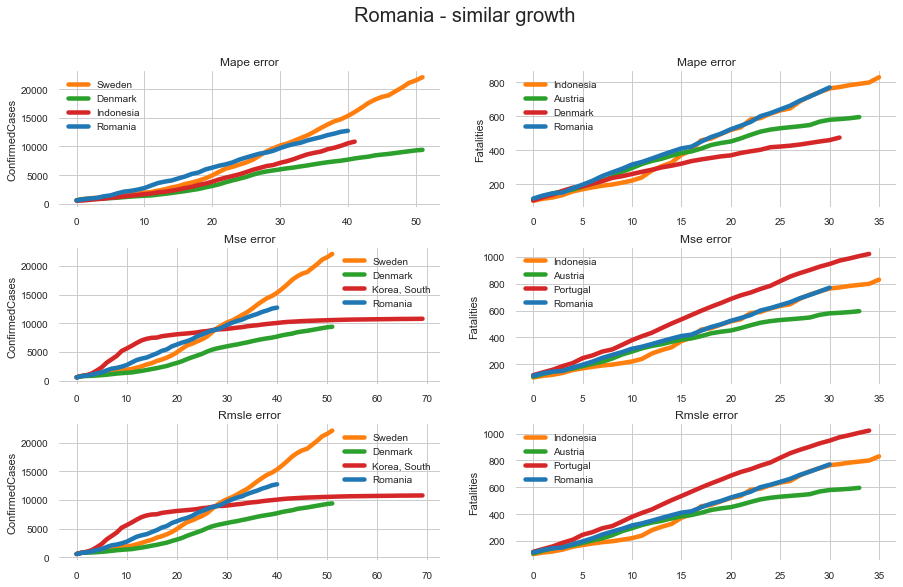

In [0]:
test_metrics(allData, 'Romania', 500, 100)

From the above comparison, 

#### 3.2.2 Evolved country

An evolved country is where the pandemic is wide spreaded and there aren't many countries with more cases than them. Such an example can be considered Italy or Spain.

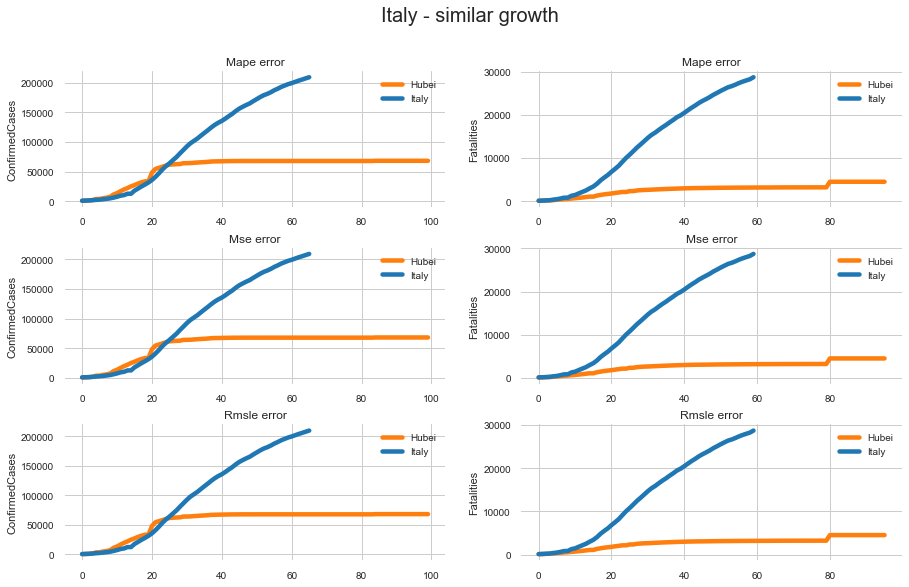

In [0]:
test_metrics(allData, 'Italy', 500, 100)

In this edge cases, the algorithm does not produce relevant results, hence there are countries that resemble the same growth.

## 4. Results

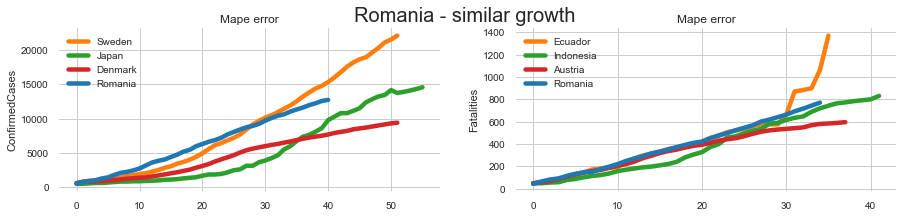

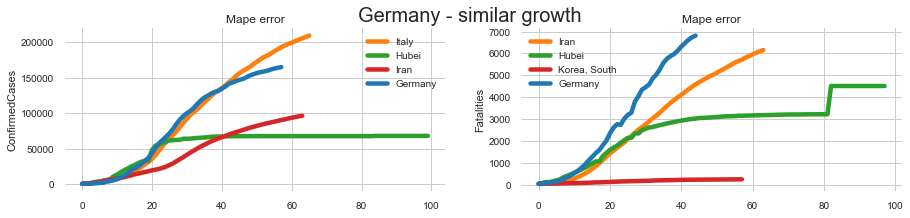

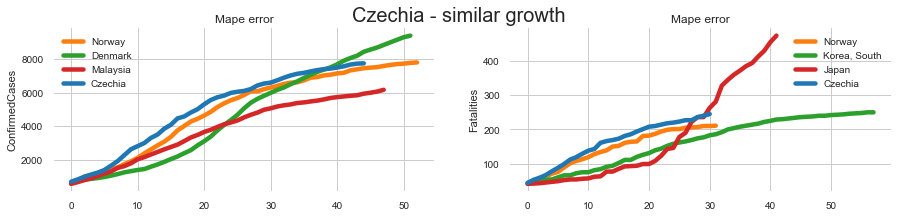

In [0]:
for country in ['Romania', 'Germany', 'Czechia']:
    r = get_nearest_sequence(allData, country, 500, 40, l1_norm_error)
    show_country_nn(allData, country, 500, 40, [r], ['MAPE'])